## Problema do prof. Castelano

Diferential Equation:
$$
\frac{dx(t)}{dt} +\frac{x(t)}{\tau} - g(t) = 0
$$

with 
$$
g(t) = c_1 V(t) + c_2V^2(t)
\\
I(t) =[ G_0 + x(t) ] V(t),
\\
V(t) = V_0*cos(wt),
$$

we want learning the $c_1$ and $c_2$. Simplifying the equations :
$$
\frac{dx(t)}{dt} +\frac{x(t)}{\tau} -  c_1  V_0*cos(wt) - c_2 V_0^2*cos^2(wt) = 0
$$

with 
$$
\frac{I(t)}{V_0*cos(wt)} - G_0 -  x(t)=0 ,
$$


## ..

In [1]:
#from sklearn import linear_model
from torch import nn
from numpy.random import randint

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import torch  as tc

In [2]:
class SineActivation(nn.Module):
    def __init__(self): 
        super(SineActivation, self).__init__() 
    def forward(self, x):
        return tc.sin(x)
    
class Regressao_M(nn.Module):
    def __init__(self, neuronio, M, output=1, activation=nn.Mish(), creat_p=False, N_of_paramater=1):
        super().__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output
        self.creat_p = creat_p
        self.N_of_paramater = N_of_paramater

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

        if creat_p:
            #self.acceleration = nn.Parameter(tc.rand(N_of_paramater))
            self.acceleration = nn.Parameter(tc.ones(N_of_paramater)*2)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x


Lets consider  a = 4, b = 1, $V_0$ = 1 , $\tau$ = 1 e $w$ = $1/\tau$ =1 then 

$$
Loss_{edo} = \frac{dx(t)}{dt} + x(t)  - c_1 data_{V(t)} - c_2[data_{V(t)}]^2  
$$

and   
$$
Loss_{data} =  data_{I(t)}/data_{V(t)} -  4 - x(t)
$$

The time range is $[0,2\pi]$

In [3]:
def analitics_solution(N,a,b,c1,c2,V0,tau):
    w  = 1/(tau)
    dt = 2*np.pi/N
    
    def F(w,t,c1,c2):
        p  = tau*w
        d1 = 2*(1+(p)**2)
        d2 = (1+(2*p)**2)
        return c1*tau*V0/d1*(np.cos(w*t) + p*np.sin(w*t))+c2*tau*V0**2/2*(1+1/d2*(np.cos(2*w*t)+2*p*np.sin(2*w*t)))
    n = np.zeros(N+1)
    I = np.zeros(N+1)
    V = np.zeros(N+1)
    t = np.zeros(N+1)
    for i in range(N+1):
        t[i]=(i)*dt
        V[i]=V0*np.cos(w*t[i])
        I[i]=(a+b*F(w,t[i],c1,c2))*V[i]
    return t,I,V


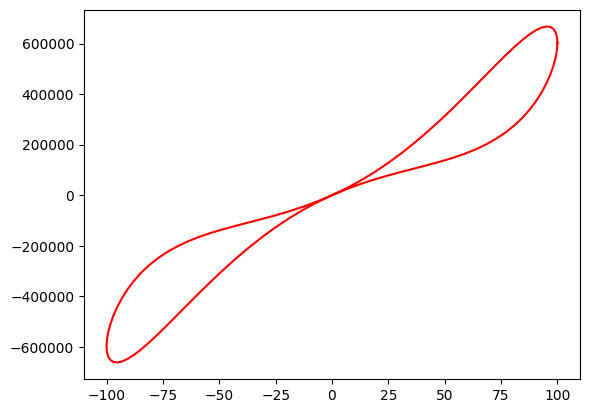

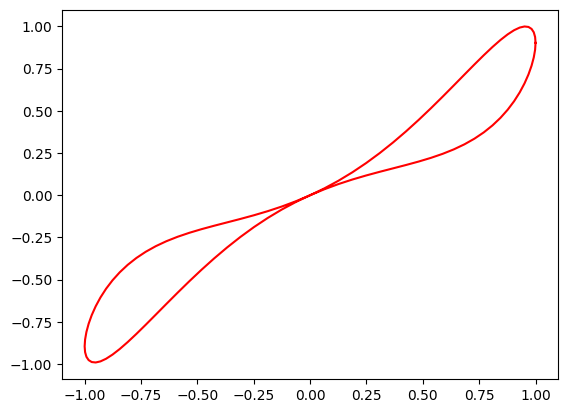

In [4]:

time,corrent,d_potencial = analitics_solution(N=100,a=1,b=1,c1=1,c2=1,V0=100,tau=1)
plt.plot(d_potencial,corrent,"r-")
plt.show()
corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()

plt.plot(d_potencial,corrent,"r-")
plt.show()

In [5]:
#generation of data
def numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0):
    def f(t,q,V):
        r=-q/tau+c1*V+c2*V**2+c3*V**3+c4*V**4
        return r
    def v(t,w):
        return V0*np.cos(w*t)
    Nc = 4
    dt = 2*np.pi/(N)/w

    n  = np.zeros(N)
    I  = np.zeros(N)
    V  = np.zeros(N)
    t  = np.zeros(N)
    n[0] = 6
    I[0] = 1
    t[0] = 0
    V[0] = v(t[0],w)
    for j in range(Nc):
        if j>1:
            n[0]=n[-1]
            I[0]=I[-1]
        for i in range(N-1):
        #RK4
            t[i+1]=t[i]+dt
            k1=dt*f(t[i],n[i],v(t[i],w));
            k2=dt*f(t[i]+dt/2,n[i]+k1/2,v(t[i]+dt/2,w));
            k3=dt*f(t[i]+dt/2,n[i]+k2/2,v(t[i]+dt/2,w));
            k4=dt*f(t[i]+dt,n[i]+k3,v(t[i]+dt,w));
            n[i+1]=n[i]+(1.0/6.0)*(k1+k4+2.0*(k2+k3))
            I[i+1]=(G0+n[i+1])*v(t[i+1],w)
            V[i+1]=v(t[i+1],w)
    return t,I,V,n



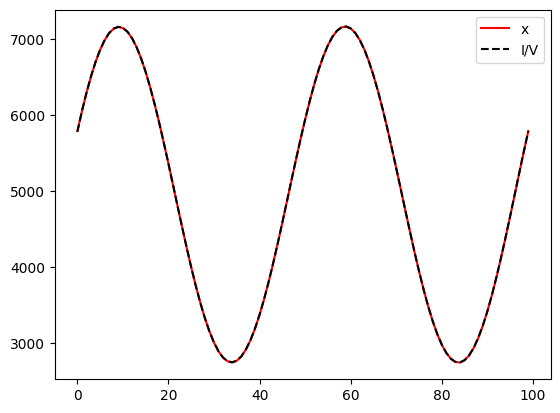

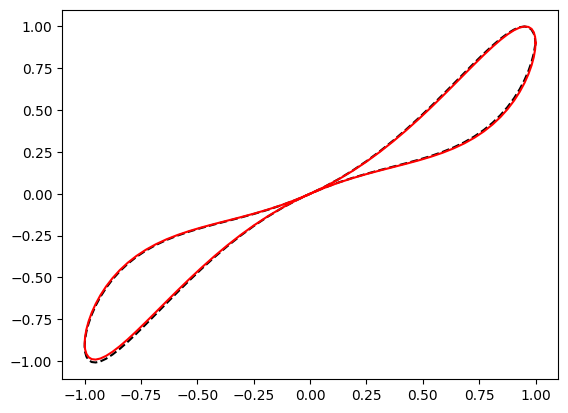

In [6]:
N=100;G0=1;c1=1.0;c2=1;c3=0;c4=0;tau=1;w=1;V0=100;
time,current,potential,dn = numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0)
   
plt.plot(dn,"r",label="x")
plt.plot(current/potential,"k--",label="I/V")
plt.legend()
plt.show()
plt.plot(potential/potential.max(),current/current.max(),"k--")
plt.plot(d_potencial,corrent,"r-")
plt.show()

Porque o resultado da equaçao diferencial está dano igual ao I/V.

Os resultados estão diferentes para valroes pequeno de V0

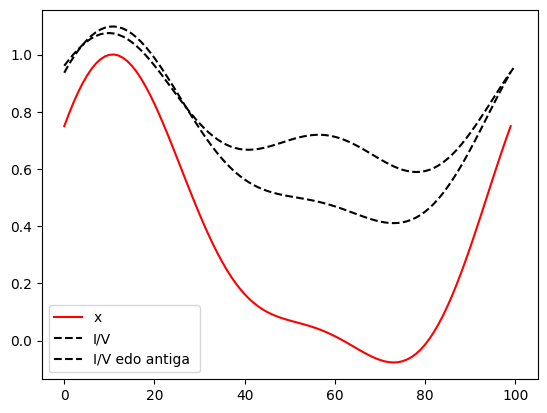

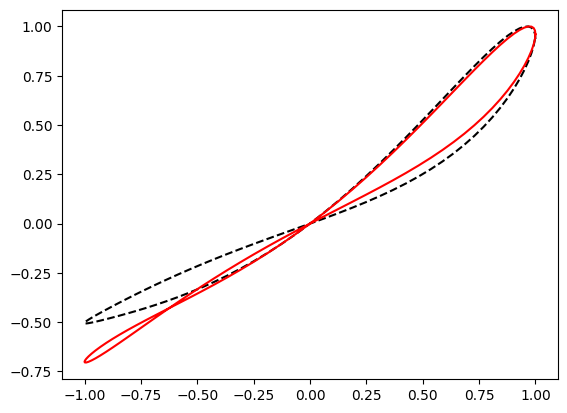

In [14]:
N=100;G0=1;c1=1.0;c2=1;c3=0;c4=0;tau=1;w=1;V0=1;
time,current,potential,dn = numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0)
current,potential = current/current.max(),potential/potential.max()



time,corrent,d_potencial = analitics_solution(N=100,a=1,b=1,c1=1,c2=1,V0=V0,tau=1)
corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()

plt.plot(dn/dn.max(),"r",label="x")
plt.plot(current/potential,"k--",label="I/V")
plt.plot(corrent/d_potencial,"k--",label="I/V edo antiga ")
plt.legend()
plt.show()

plt.plot(potential/potential.max(),current/current.max(),"k--")
plt.plot(d_potencial,corrent,"r-")
plt.show()

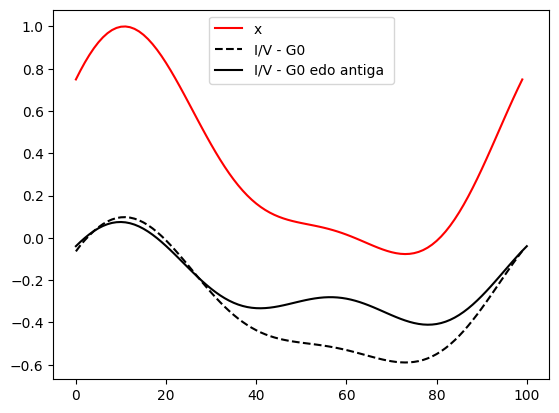

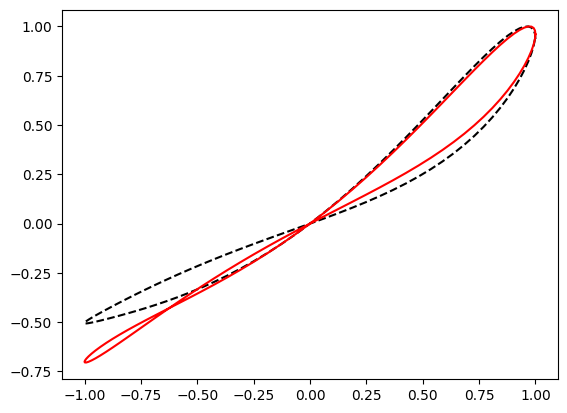

In [11]:
N=100;G0=1;c1=1.0;c2=1;c3=0;c4=0;tau=1;w=1;V0=1;
time,current,potential,dn = numerical_solution2(N,G0,c1,c2,c3,c4,tau,w,V0)
current,potential = current/current.max(),potential/potential.max()



time,corrent,d_potencial = analitics_solution(N=100,a=G0,b=1,c1=1,c2=1,V0=V0,tau=1)
corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()

plt.plot(dn/dn.max(),"r",label="x")
plt.plot(current/potential -G0,"k--",label="I/V - G0")
plt.plot(corrent/d_potencial-G0,"k-",label="I/V - G0 edo antiga ")
plt.legend()
plt.show()

plt.plot(potential/potential.max(),current/current.max(),"k--")
plt.plot(d_potencial,corrent,"r-")
plt.show()

In [9]:
asas

NameError: name 'asas' is not defined

### EDO solution

In [ ]:
def traino(lr_,neuronio_,camadas,fun_activation,epochs=1000,a_=4,b_=1,c1_=1.0,c2_=1.0,V0_=1):
    # Criando os dados de treino
    time,corrent,d_potencial = analitics_solution(N=100,a=a_,b=b_,c1=c1_,c2=c2_,V0=V0_,tau=1)

    corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()
    t_train = tc.tensor(time,requires_grad=True,dtype=tc.float).reshape(-1,1)
    I_data  = tc.tensor(corrent,dtype=tc.float).reshape(-1,1)
    V_data  = tc.tensor(d_potencial,dtype=tc.float).reshape(-1,1)

    # criando o modelo

    model = Regressao_M(neuronio = neuronio_,M=camadas,output=1,activation=fun_activation,creat_p = True,N_of_paramater = 3)
    opt = tc.optim.Adam(params=model.parameters(),lr=lr_,betas=(0.9,0.999))
    lr_step = tc.optim.lr_scheduler.StepLR(opt, step_size=500, gamma=0.9)
    LOSS = []
    
    for _ in range(epochs):
        model.train()
        x_preds = model(t_train)
        #a_,b_,C_1,C_2 = model.acceleration
        G0,C_1,C_2 = model.acceleration
        ###########################################################################
        # Derivando
        dx_dt = tc.autograd.grad(x_preds,t_train, grad_outputs=tc.ones_like(x_preds), create_graph=True,retain_graph=True)[0]
        # Edo
        loss_ode_dydt = tc.mean( abs(dx_dt + x_preds -C_1*V_data - C_2*(V_data)**2) ) # d
        # Usando os dado experimentais
        loss_data = tc.mean(abs(I_data/V_data - (G0 + b_*x_preds)*V_data ) )
        
        loss = loss_ode_dydt + loss_data 
        ############################################################################
        LOSS.append(loss.detach().numpy())
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
        lr_step.step()
    
    plt.plot(x_preds.detach().numpy(),"k.-")
    plt.plot((I_data/V_data).detach().numpy(),"r--")
    plt.show()
    # Primeiro subplot
    
    plt.plot(LOSS,label="Treino")
    plt.legend()
    plt.yscale('log')
    plt.show()
    # Segundo subplot a_,b_,C_1,C_2 = model.acceleration

    G0,C_1,C_2 = model.acceleration.detach().numpy()
    time,corrent,d_potencial = analitics_solution(N=100,a=a_,b=b_,c1=C_1,c2=C_2,V0=V0_,tau=1)
    corrent,d_potencial = corrent/corrent.max(),d_potencial/d_potencial.max()
    plt.plot(d_potencial,corrent,"r-",label='Predict')
    plt.plot(V_data,I_data,"k--",label='Data')

    plt.ylabel('I(t)')
    plt.xlabel('V(t)')
    plt.grid(True)
    plt.legend()
    plt.show()
    print(f"lr:{lr_} neuronio_ {neuronio_} camadas {camadas} fun_activation{fun_activation} ")
    print(f" Parametros : a = {G0}, b = {1}, C_1 ={C_1*2}, C_2 = {C_2} |")

Resultado esperado a=4,b=1,c1=2.0,c2=1.0

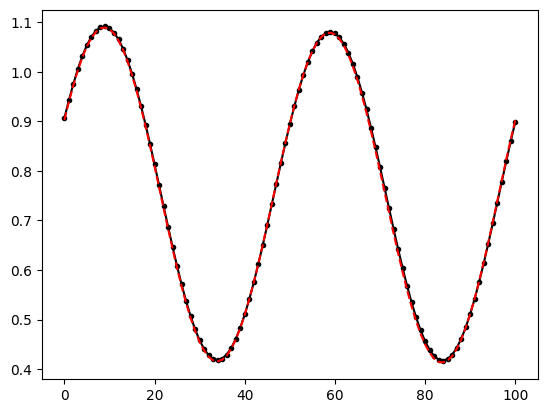

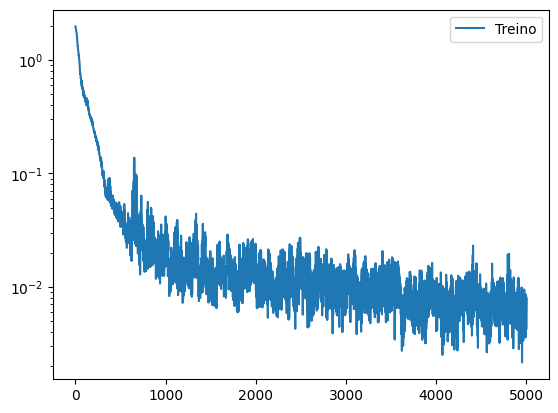

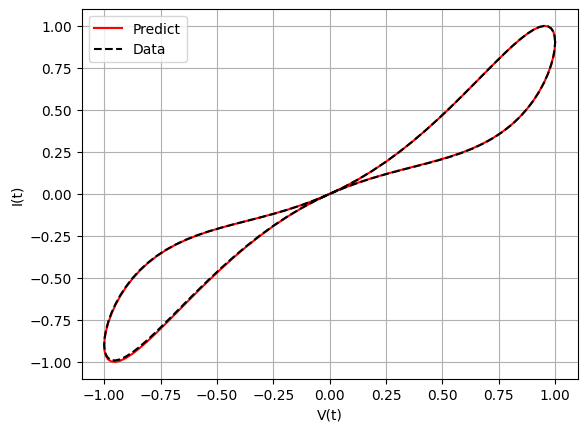

lr:0.01 neuronio_ 10 camadas 5 fun_activationSineActivation() 
 Parametros : a = 0.0001598256640136242, b = 1, C_1 =0.01725505106151104, C_2 = 1.4960200786590576 |


In [ ]:
traino(lr_=0.01,neuronio_=10,camadas=5,fun_activation=SineActivation(),epochs=5000,a_=1,b_=1,c1_=1.0,c2_=1.0,V0_=100)

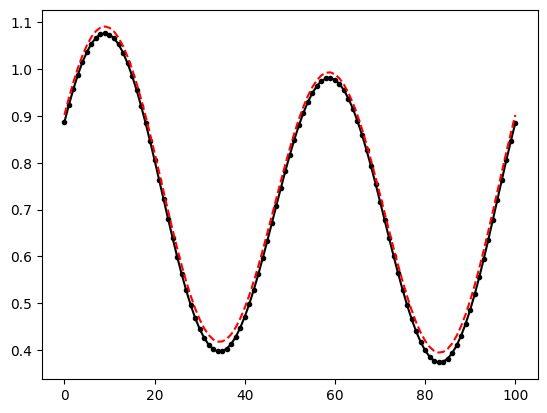

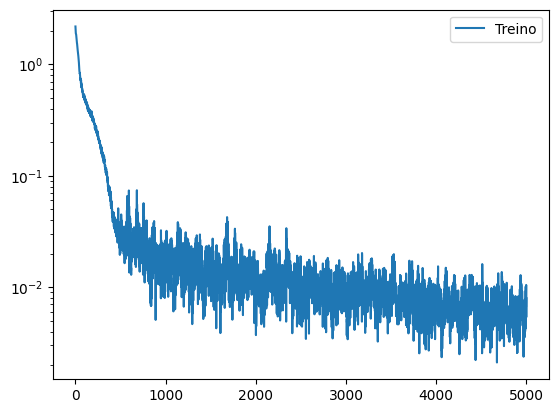

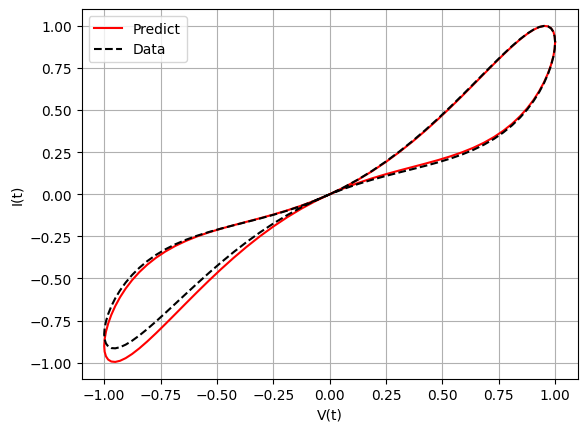

lr:0.01 neuronio_ 10 camadas 5 fun_activationSineActivation() 
 Parametros : a = 0.014665303751826286, b = 1, C_1 =0.14135248959064484, C_2 = 1.4185492992401123 |


In [ ]:
traino(lr_=0.01,neuronio_=10,camadas=5,fun_activation=SineActivation(),epochs=5000,a_=1,b_=1,c1_=1.0,c2_=1.0,V0_=10)

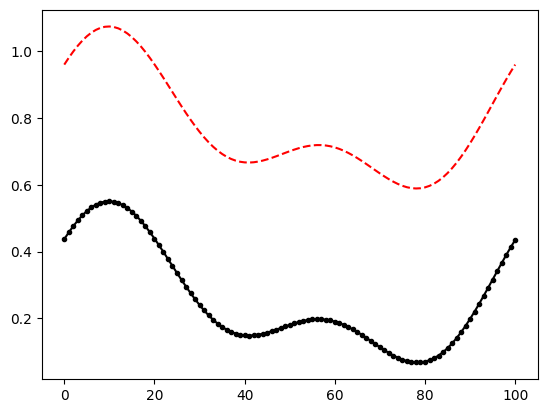

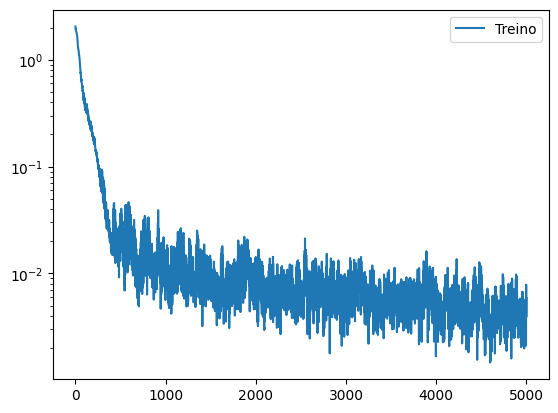

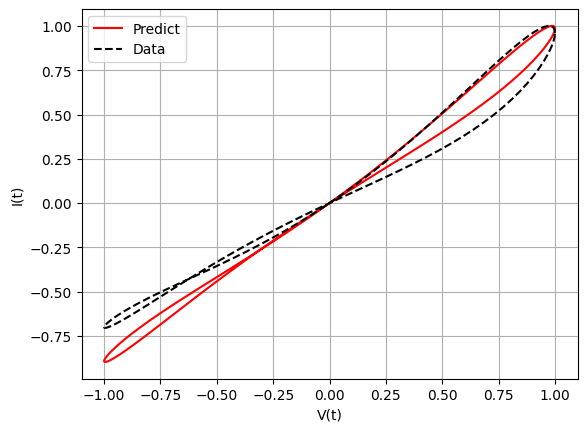

lr:0.01 neuronio_ 10 camadas 5 fun_activationSineActivation() 
 Parametros : a = 0.5199567079544067, b = 1, C_1 =0.5206870436668396, C_2 = 0.5170345902442932 |


In [ ]:
traino(lr_=0.01,neuronio_=10,camadas=5,fun_activation=SineActivation(),epochs=5000,a_=1,b_=1,c1_=1.0,c2_=1.0,V0_=1)

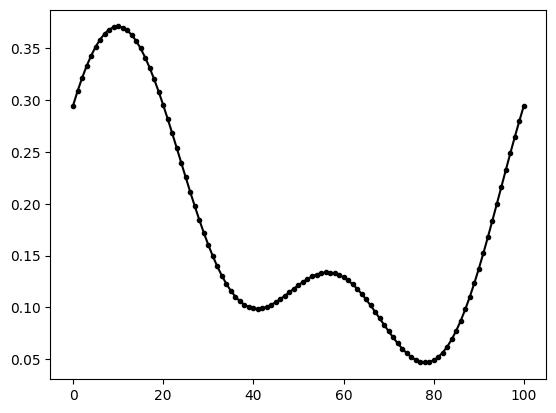

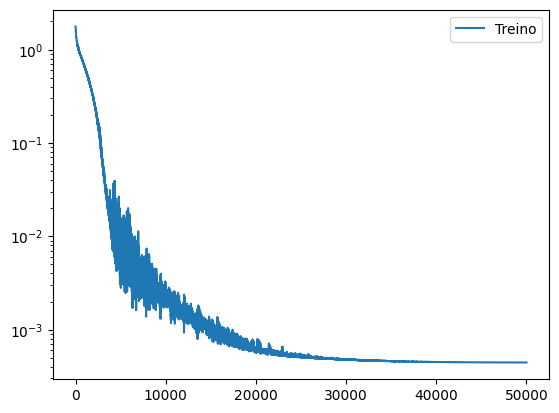

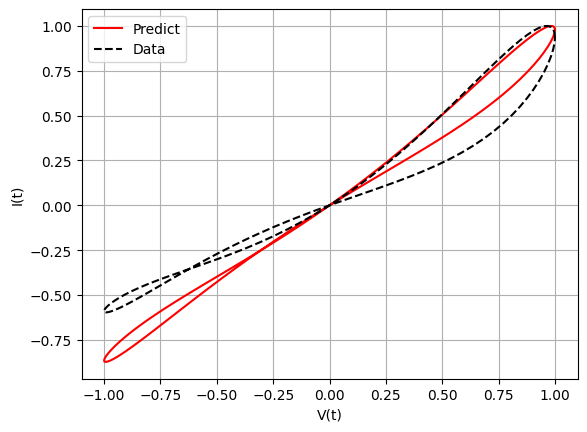

lr:0.001 neuronio_ 100 camadas 2 fun_activationSineActivation() 
 Parametros : a = 0.3468485474586487, b = 1, C_1 =0.34684401750564575, C_2 = 0.34683236479759216 |


In [ ]:
traino(lr_=0.001,neuronio_=100,camadas=2,fun_activation=SineActivation(),epochs=50000,a_=1,b_=2,c1_=1.0,c2_=1.0,V0_=1)

3


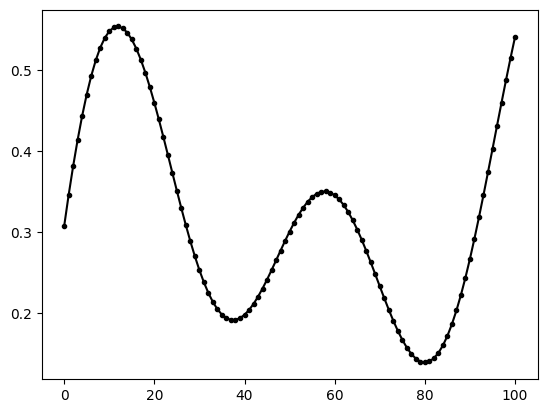

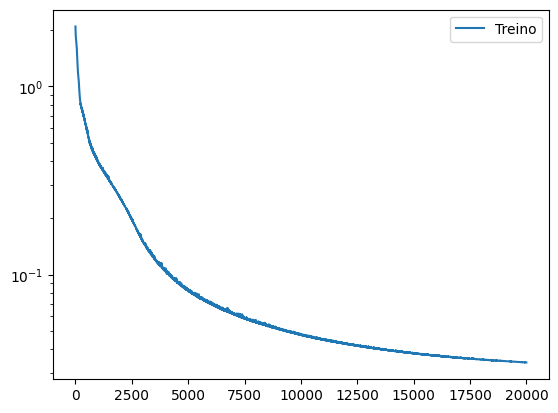

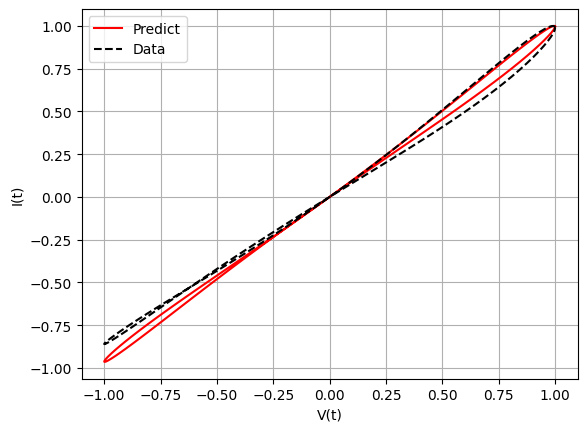

lr:0.001 neuronio_ 20 camadas 3 fun_activationSineActivation() 
 Parametros : a = 0.5601900815963745, b = 1, C_1 =0.46271106600761414, C_2 = 0.710759699344635 |


In [ ]:
a= randint(0,10)
print(a)
traino(lr_=0.001,neuronio_=20,camadas=3,fun_activation=SineActivation(),epochs=20000,a_=a,b_=1,c1_=1.0,c2_=1.0,V0_=1)

8


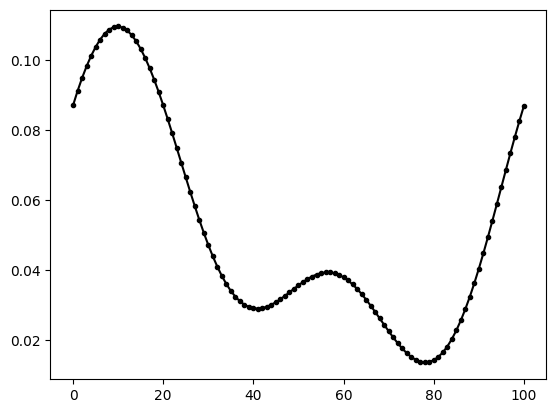

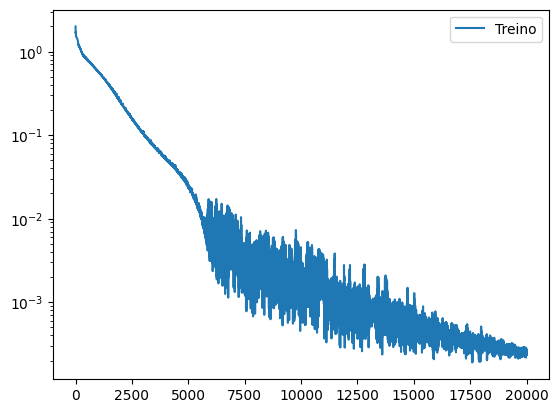

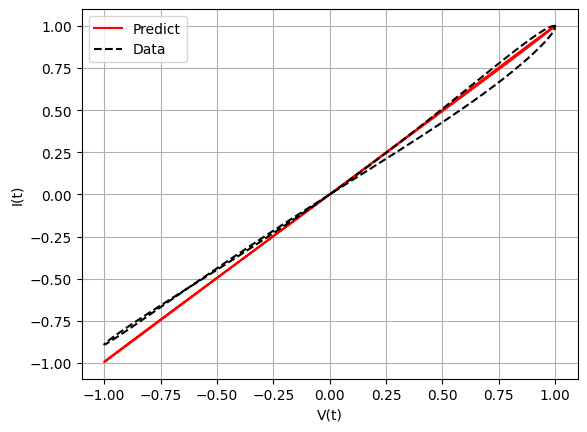

lr:0.001 neuronio_ 50 camadas 3 fun_activationSineActivation() 
 Parametros : a = 0.8184254765510559, b = 1, C_1 =0.10236039757728577, C_2 = 0.10238852351903915 |


In [ ]:
a= randint(0,10)
print(a)
traino(lr_=0.001,neuronio_=50,camadas=3,fun_activation=SineActivation(),epochs=20000,a_=a,b_=2,c1_=1.0,c2_=1.0,V0_=1)

In [ ]:
asasa

NameError: name 'asasa' is not defined

# Bons resultados

7 9 3 9 90880


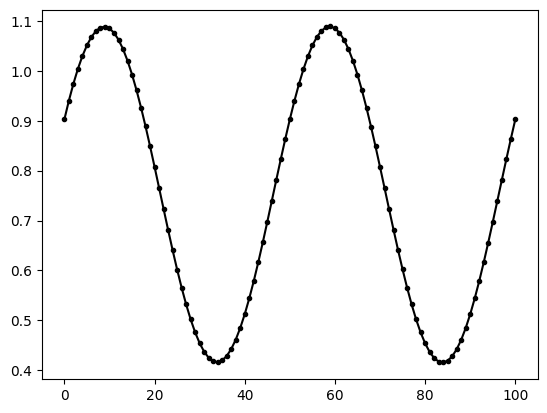

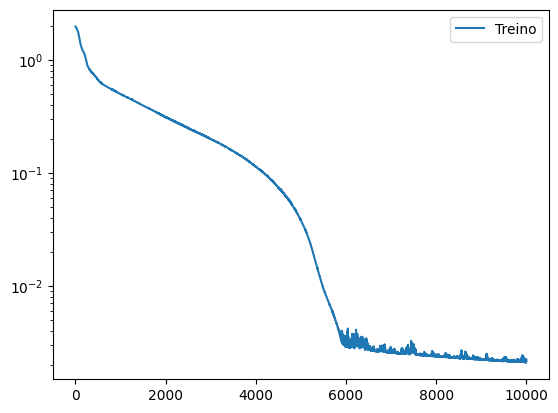

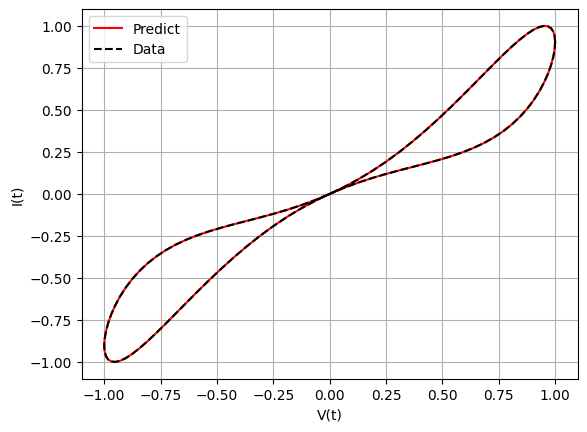

lr:0.001 neuronio_ 10 camadas 3 fun_activationSineActivation() 
 Parametros : a = 2.1055686374893412e-05, b = 1, C_1 =-1.6186801076401025e-05, C_2 = 1.5054563283920288 |


In [ ]:
a,b,c1,c2,V0 = randint(0,10),randint(0,10),randint(0,10),randint(0,10),randint(0,100000)
print(a,b,c1,c2,V0)
traino(lr_=0.001,neuronio_=10,camadas=3,fun_activation=SineActivation(),epochs=10000,a_=a,b_=b,c1_=c1,c2_=c2,V0_=V0)

7 9 3 5 69202


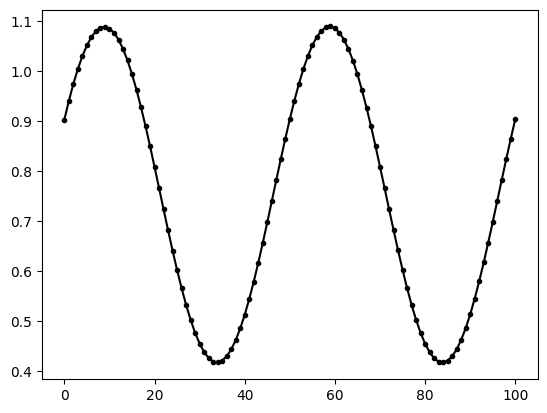

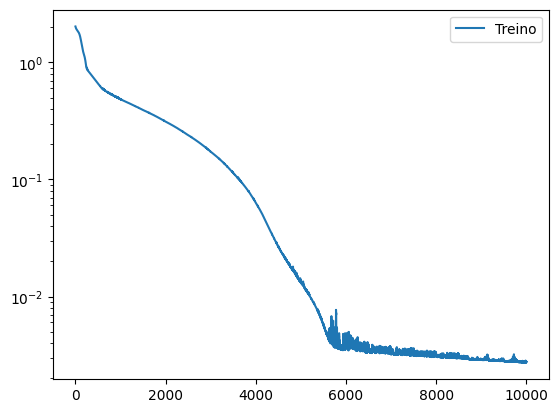

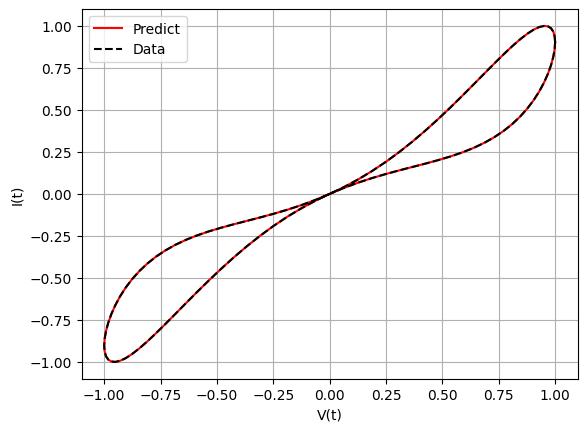

lr:0.001 neuronio_ 10 camadas 3 fun_activationSineActivation() 
 Parametros : a = -0.00012598262401297688, b = 1, C_1 =7.948074926389381e-05, C_2 = 1.5054826736450195 |


In [ ]:
a,b,c1,c2,V0 = randint(0,10),randint(0,10),randint(0,10),randint(0,10),randint(0,100000)
print(a,b,c1,c2,V0)
traino(lr_=0.001,neuronio_=10,camadas=3,fun_activation=SineActivation(),epochs=10000,a_=a,b_=b,c1_=c1,c2_=c2,V0_=V0)

7 6 6 1 3262


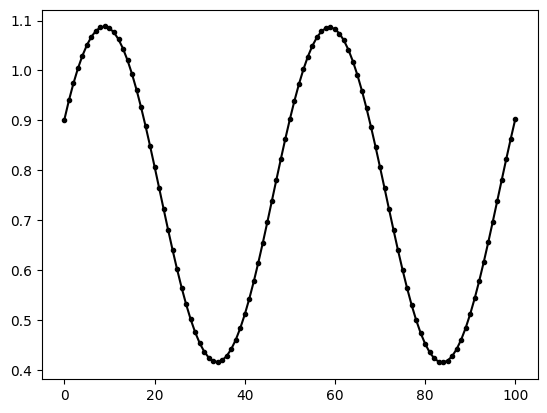

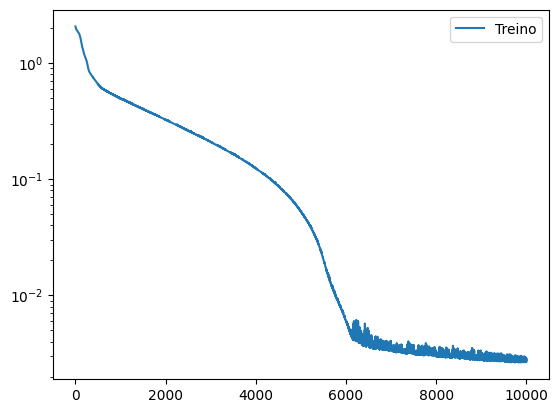

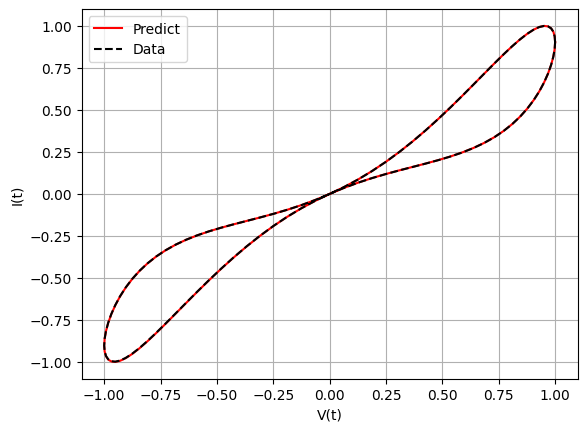

lr:0.001 neuronio_ 10 camadas 3 fun_activationSineActivation() 
 Parametros : a = 0.0002678458404261619, b = 1, C_1 =0.00292391050606966, C_2 = 1.5041532516479492 |


In [ ]:
a,b,c1,c2,V0 = randint(0,10),randint(0,10),randint(0,10),randint(0,10),randint(0,100000)
print(a,b,c1,c2,V0)
traino(lr_=0.001,neuronio_=10,camadas=3,fun_activation=SineActivation(),epochs=10000,a_=a,b_=b,c1_=c1,c2_=c2,V0_=V0)

0 9 8 5 724


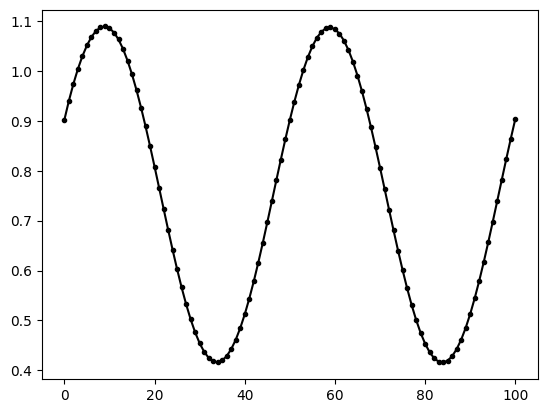

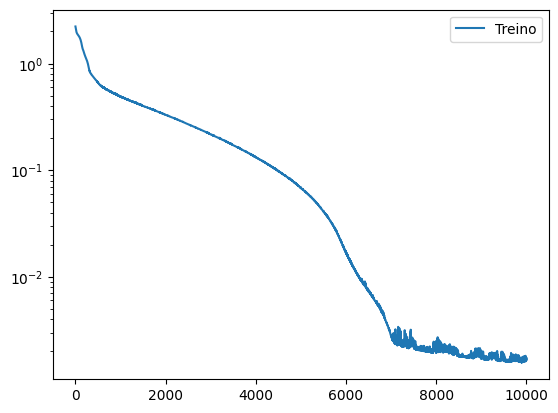

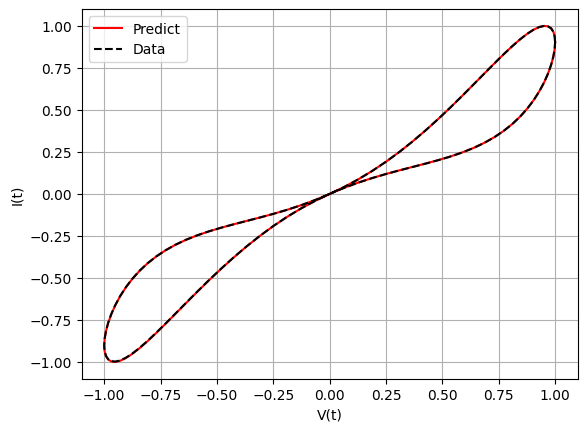

lr:0.001 neuronio_ 10 camadas 3 fun_activationSineActivation() 
 Parametros : a = 4.9816808314062655e-05, b = 1, C_1 =0.0034882444888353348, C_2 = 1.5037682056427002 |


In [ ]:
a,b,c1,c2,V0 = randint(0,10),randint(0,10),randint(0,10),randint(0,10),randint(0,1000)
print(a,b,c1,c2,V0)
traino(lr_=0.001,neuronio_=10,camadas=3,fun_activation=SineActivation(),epochs=10000,a_=a,b_=b,c1_=c1,c2_=c2,V0_=V0)